In [62]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
tf.config.list_physical_devices('GPU')

[]

In [63]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [73]:
def generate_cam(model, item, layer_name=None, debug=False):  # debug 매개변수 추가
    # 이미지 전처리
    img = tf.cast(item['image'], tf.float32)
    img = tf.expand_dims(img, axis=0)
    
    if debug:
        print(f"Input image shape: {img.shape}")
        plt.figure(figsize=(5, 5))
        plt.imshow(item['image'])
        plt.title("Original image")
        plt.show()
        
    # 레이어 이름 지정 (기본값: 마지막 합성곱 층)
    if layer_name is None:
        layer_name = [l.name for l in model.layers 
                     if 'conv' in l.name][-1]
        if debug:
            print(f"Using layer: {layer_name}")

    # Grad-CAM 모델 생성
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # 그라디언트 계산
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 히트맵 생성
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # 원본 이미지에 오버레이
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap('jet')
    colored_heatmap = jet(np.uint8(heatmap))[..., :3]
    cam_image = (colored_heatmap * 0.4 + img[0].numpy() * 0.5).astype(np.uint8)
    
    if debug:
        plt.figure(figsize=(5, 5))
        plt.imshow(heatmap, cmap='jet')
        plt.title("Raw heatmap")
        plt.colorbar()
        plt.show()
    
    return cam_image


Input image shape: (1, 175, 225, 3)


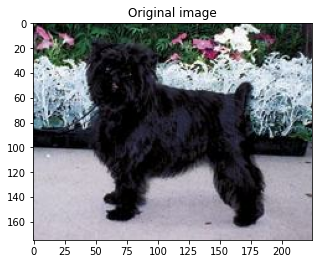

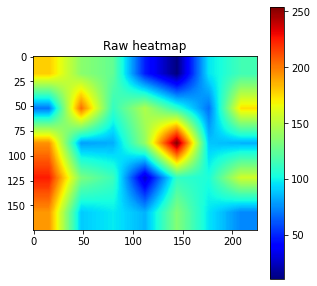

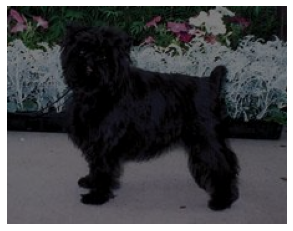

In [83]:
cam_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
x = cam_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)


model = tf.keras.Model(inputs=cam_model.inputs, outputs=predictions)

# CAM 생성 및 시각화
for item in ds_test.take(1):
    cam_image = generate_cam(model, item, layer_name='block_16_expand_relu', debug=True)
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()
    
    # CAM 생성 및 시각화
for item in ds_test.take(1):
    cam_image = generate_cam(model, item, layer_name='block_16_expand_relu', debug=True)
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()


Input image shape: (1, 332, 500, 3)


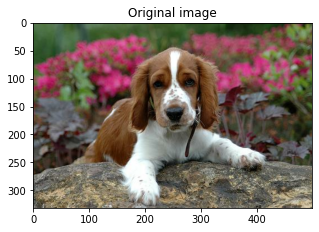

Using layer: expanded_conv_project_BN


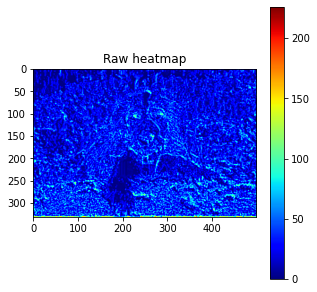

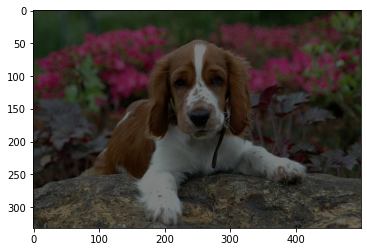

In [80]:
cam_image = generate_cam(model, item, debug=True)
plt.imshow(cam_image)

In [84]:
cam_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_16[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# 회고
함수구현을 잘 못하여,주말을 통해 새롭게 진행할 예정입니다.